In [1]:
import keyring
import pandas as pd
from sqlalchemy import create_engine

password = keyring.get_password("mysql-rocketpig", "root")
user = 'root'
host = '220.76.59.96'
port = '3306'  # 기본적으로 MySQL은 3306 포트를 사용합니다
db = 'stock_db'

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset=utf8")

# 연결 테스트
with engine.connect() as connection:
    print("SQLAlchemy로 MySQL 연결 성공!")

SQLAlchemy로 MySQL 연결 성공!


In [4]:
query = "SELECT * FROM deposit"
입금 = pd.read_sql(query, con=engine)
입금.set_index('거래일', inplace=True)
query = "SELECT * FROM withdraw"
출금 = pd.read_sql(query, con=engine)
출금.set_index('거래일', inplace=True)
query = "SELECT * FROM distribution"
분배금 = pd.read_sql(query, con=engine)
분배금.set_index('거래일', inplace=True)
query = "SELECT * FROM interest"
이자 = pd.read_sql(query, con=engine)
이자.set_index('거래일', inplace=True)

In [5]:
일별입금 = 입금.groupby('거래일').agg({'정산금': 'sum'})
일별출금 = 출금.groupby('거래일').agg({'정산금': 'sum'})
일별분배금 = 분배금.groupby('거래일').agg({'정산금': 'sum'})
일별이자 = 이자.groupby('거래일').agg({'정산금': 'sum'})

일별입금 = 일별입금.resample('D').sum().fillna(0)
일별출금 = 일별출금.resample('D').sum().fillna(0)
일별분배금 = 일별분배금.resample('D').sum().fillna(0)
일별이자 = 일별이자.resample('D').sum().fillna(0)

일별입금.columns = ['입금']
일별출금.columns = ['출금']
일별분배금.columns = ['분배금']
일별이자.columns = ['이자']
입출금 = pd.concat([일별입금, 일별출금, 일별분배금, 일별이자], axis=1).fillna(0)
입출금['잔고1'] = 입출금['입금'] - 입출금['출금']
입출금['잔고1'] = 입출금['잔고1'].cumsum()
입출금['잔고2'] = 입출금['입금'] - 입출금['출금'] + 입출금['분배금'] + 입출금['이자']
입출금['잔고2'] = 입출금['잔고2'].cumsum()

# 일별입출금 = 입금['정산금'] - 출금['정산금']
# 입출금 = pd.merge(일별입금, 일별출금, on='거래일', how='outer').fillna(0)
# 입출금['test'] = 입출금['잔고_x'] - 입출금['잔고_y']
# 일별입금.set_columns(['입금'])
# # display(일별입금)
# 일별입금['잔고'] = 일별입금['입금'].cumsum()

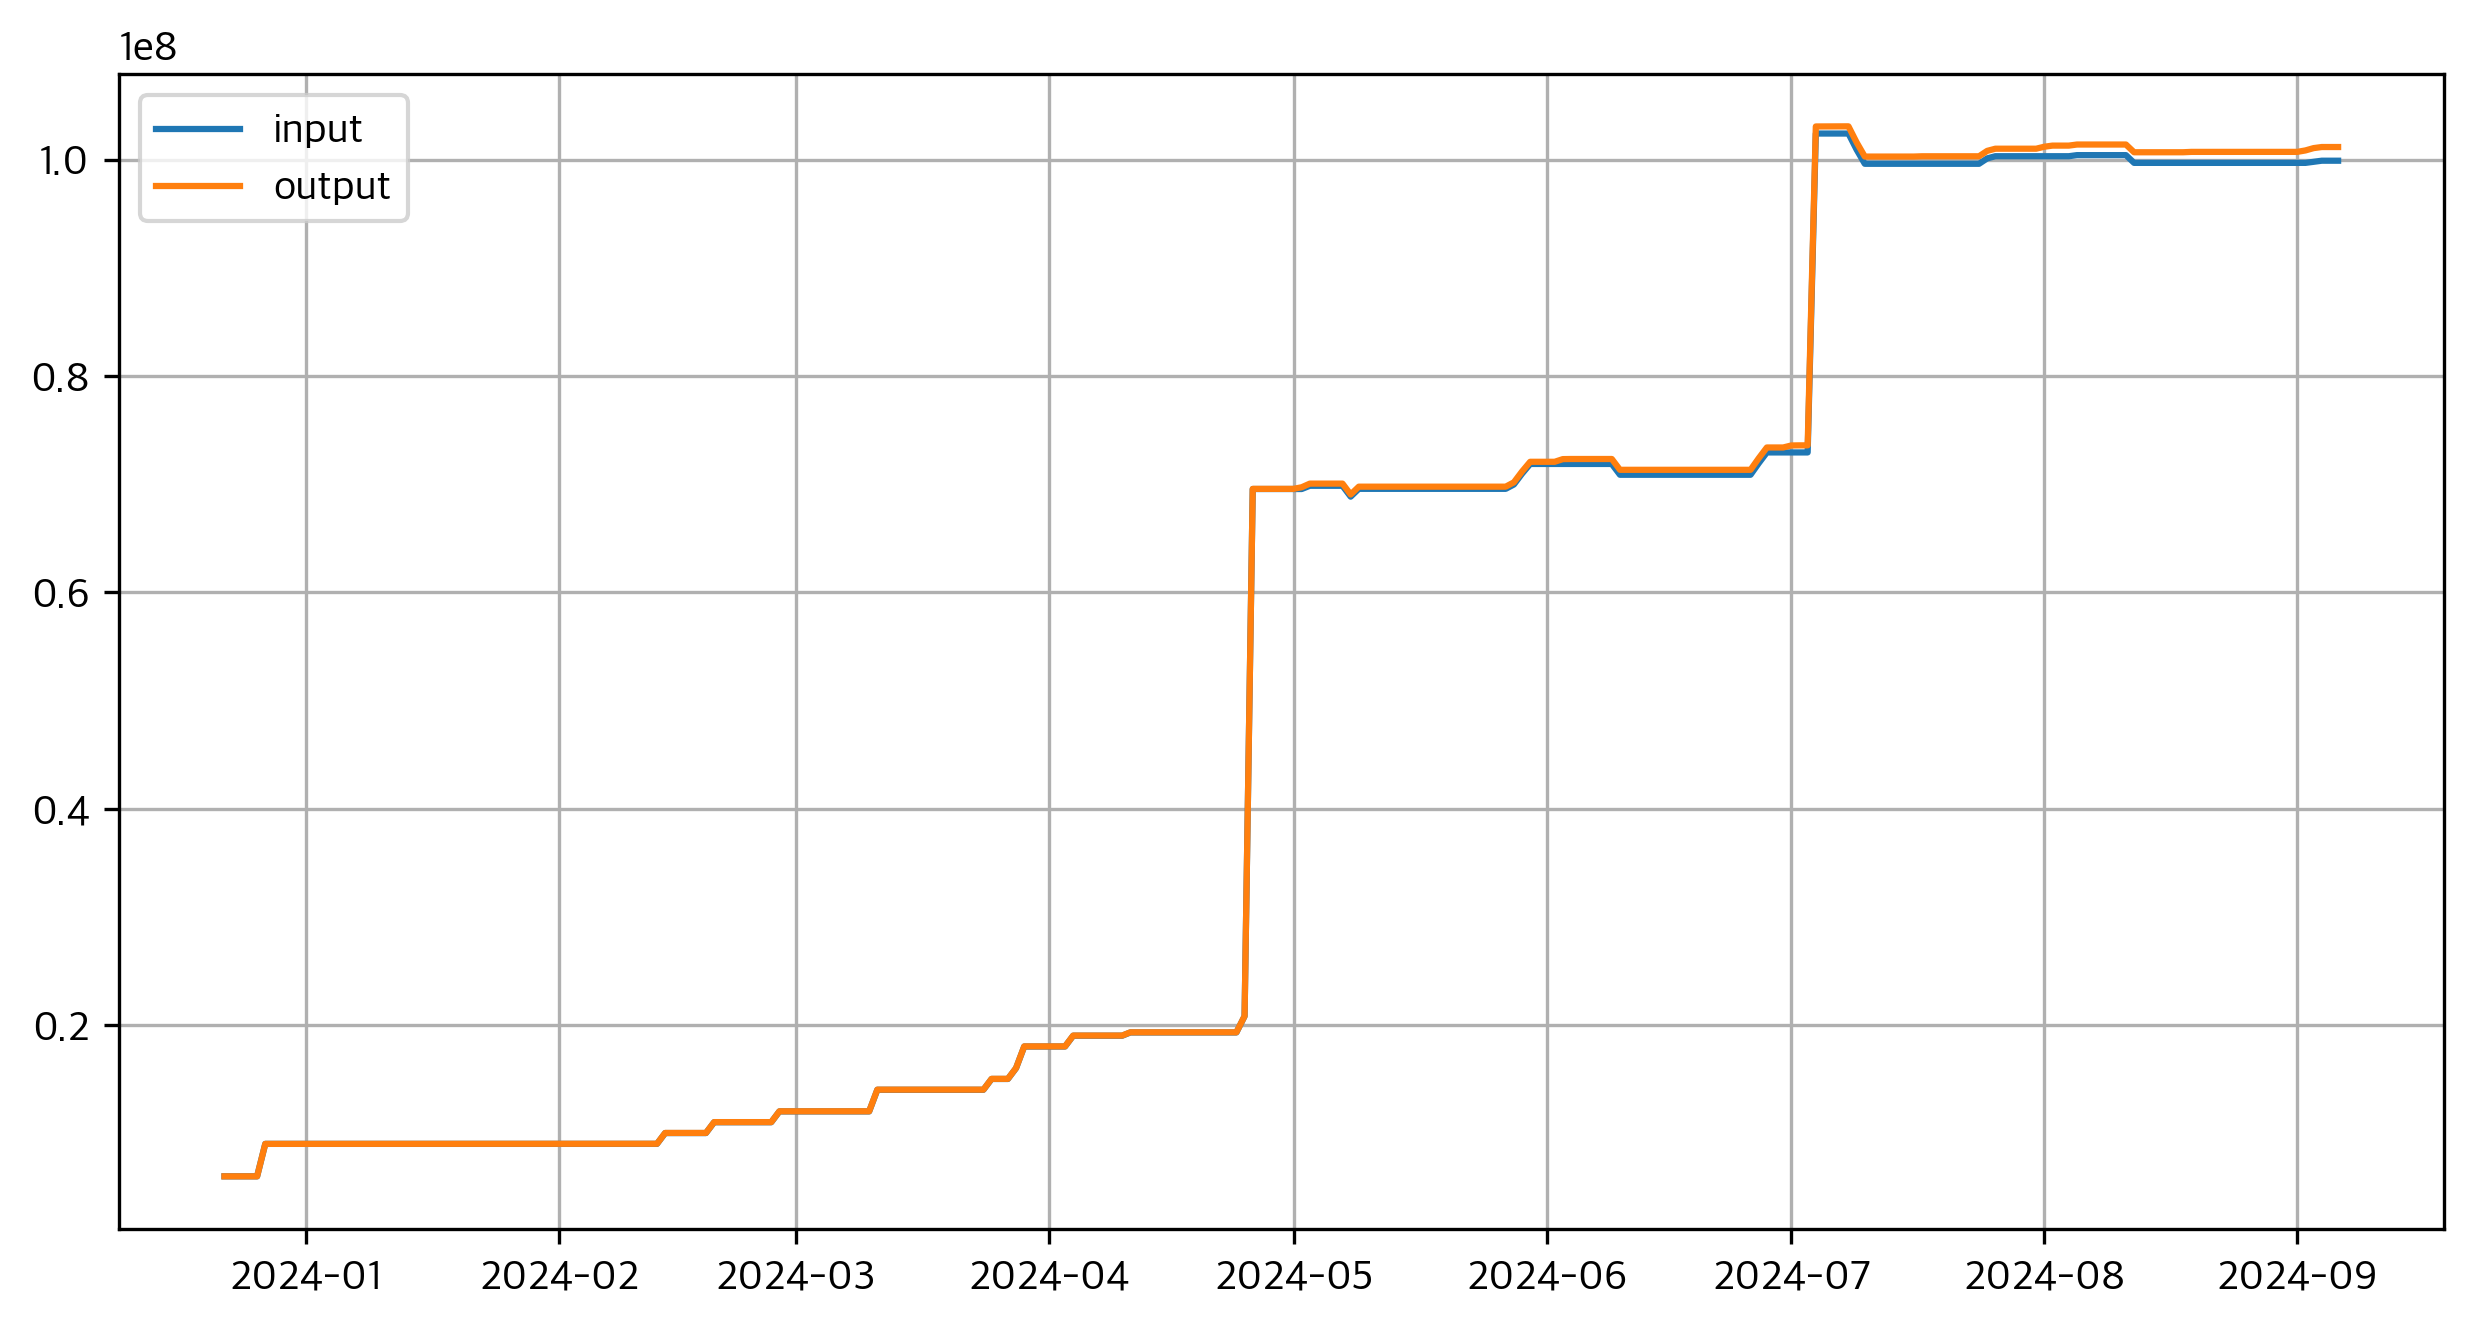

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(입출금['잔고1'], label='input')
plt.plot(입출금['잔고2'], label='output')
plt.grid(True)
plt.legend()